In [1]:
# imports 
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
import random
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer


torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

In [16]:
# Densenet121 model as defined in PyTorch
class DenseNet121(nn.Module):
    def __init__(self, classCount):
	
        super(DenseNet121, self).__init__()
		
        # Modifying the final layer
        self.densenet121 = models.densenet121(pretrained=True)
        kernelCount = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(nn.Linear(kernelCount, classCount), nn.Sigmoid())

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [17]:
# Paths to the images
train_path = r"C:/Users/Varsha/Desktop/projects/clef23/dataset/train/"
test_path = r"C:/Users/Varsha/Desktop/projects/clef23/dataset/valid/"

In [18]:
# Label mappings
classes_df = pd.read_csv(r"C:\Users\Varsha\Desktop\projects\clef23\dataset\ImageCLEFmedical_Caption_2023_cui_mapping.csv", delimiter='\t', header=None)
classes_df.columns = ['cui','description']
classes = np.array(classes_df['cui'])

# Train and validation dataframes
train_df = pd.read_csv(r"C:\Users\Varsha\Desktop\projects\clef23\dataset\ImageCLEFmedical_Caption_2023_concept_detection_train_labels.csv", delimiter='\t')
valid_df = pd.read_csv(r"C:\Users\Varsha\Desktop\projects\clef23\dataset\ImageCLEFmedical_Caption_2023_concept_detection_valid_labels.csv", delimiter='\t')


In [19]:

valid_df['cuis']=valid_df['cuis'].str.split(';')
train_df['cuis']=train_df['cuis'].str.split(';')
train_df['ID'] = train_path+train_df['ID']+'.jpg'
valid_df['ID'] = test_path+valid_df['ID']+'.jpg'

# Binary encoding for the labels
mlb = MultiLabelBinarizer()
mlb.fit(classes)
valid_item_labels = mlb.fit_transform(valid_df['cuis'])
train_item_labels = mlb.fit_transform(train_df['cuis'])

train_images = list(train_df['ID'])
valid_images = list(valid_df['ID'])

In [20]:
# Custom Dataset class
class Dataset(Dataset):
    def __init__(self, transforms,images,labels):
        self.transforms = transforms
        self.images = images
        self.labels = labels

    def __getitem__(self, item):
        
        img = Image.open(self.images[item]).convert('RGB')
        return self.transforms(img), self.labels[item]
    
    def __len__(self):
            return len(self.images)

In [21]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations for the validation images
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transformations for the train images
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [22]:
test_dataset = Dataset(val_transform,valid_images,valid_item_labels)
train_dataset = Dataset(train_transform,train_images,train_item_labels)

In [23]:
# Parameters
num_workers = 0 
lr = 1e-4 
batch_size = 32
num_epochs = 35 
device = torch.device('cpu')
threshold = 0.5


# Loading the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))

# Initializing the model
model = DenseNet121(len(classes))
model.train()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.BCELoss()

c:\Users\Varsha\Desktop\projects\clef23\mlc\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Varsha\Desktop\projects\clef23\mlc\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Function to save checkpints 
checkpoint_path = 'checkpoints/'
def save_checkpoint(model, epoch):
    """
    model - model to be saved
    epoch - epoch number (used to keep track of the checkpoint)
    """
    filename = f"checkpoint_{epoch}.pth" 
    torch.save(model.state_dict(), checkpoint_path+filename)
    print(f"Checkpoint {filename} saved ")

Training

In [ ]:
# Training
epoch, iteration = 0, 0

while True:
    batch_losses = []
    loop = tqdm(train_dataloader)
    for idx, (images, targets) in enumerate(loop):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(images)
        loss = loss_func(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            prediction = np.array(model_result.cpu().numpy() > threshold)
            result =  f1_score(y_true=targets.cpu().numpy(), y_pred=model_result.cpu().numpy(), average='micro')

        model.train()

    model.eval()
    with torch.no_grad():
        model_result = []
        targets = []
        for images, batch_targets in test_dataloader:
            images = images.to(device)
            model_batch_result = model(images)
            model_result.extend(model_batch_result.cpu().numpy())
            targets.extend(batch_targets.cpu().numpy())
    
    loss_value = np.mean(batch_losses)
    print(f"epoch:{epoch} f1 score: {result}")

    loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
    loop.set_postfix(loss=torch.rand(1).item(), acc=torch.rand(1).item())
    
    save_checkpoint(model,epoch)
    
    epoch += 1
    if epoch >= num_epochs:
        break

Testing

In [27]:
checkpoint = torch.load("checkpoint-000000.pth",map_location=device)
model.load_state_dict(checkpoint)
model.eval()

DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

Making a sample prediction

Predicted labels - 
['C0040405']
['X-Ray Computed Tomography']
Actual labels - 
['C0225899' 'C3853780']
['Myocardium of left ventricle', 'Computed tomography of entire head']


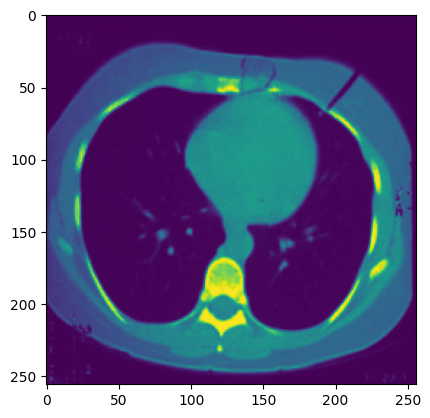

In [28]:
test_img, test_labels = test_dataset[3]

with torch.no_grad():
    prediction = model(test_img.unsqueeze(0)).cpu().numpy()[0]
    prediction = np.array(prediction > 0.5, dtype=float)

predicted_labels= classes[np.argwhere(prediction > 0)[:, 0]]
actual_labels = classes[np.argwhere(test_labels > 0)[:, 0]]
   
if len(predicted_labels):
    print(f"Predicted labels - \n{predicted_labels}")
    print([ classes_df.loc[classes_df.cui == i, 'description'].values[0] for i in predicted_labels])
    print(f"Actual labels - \n{actual_labels}")
    print([ classes_df.loc[classes_df.cui == i, 'description'].values[0] for i in actual_labels])

import matplotlib.pyplot as plt
plt.imshow(test_img[0,:,:])
plt.show()